<a href="https://colab.research.google.com/github/abhinsuresh/MLTSA_ASuresh/blob/master/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing required packages, plot style parameters and csv data

In [0]:
import pandas as pd
import pylab as pl
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

In [3]:
url = "https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A.csv"
grbAG = pd.read_csv(url)
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


#Making another column with log of time

In [4]:
grbAG["logtime"] = pl.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


#Visualizing the data with error bars for each wavelength range, plotting the flux of each of the photometric band vs  log time

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


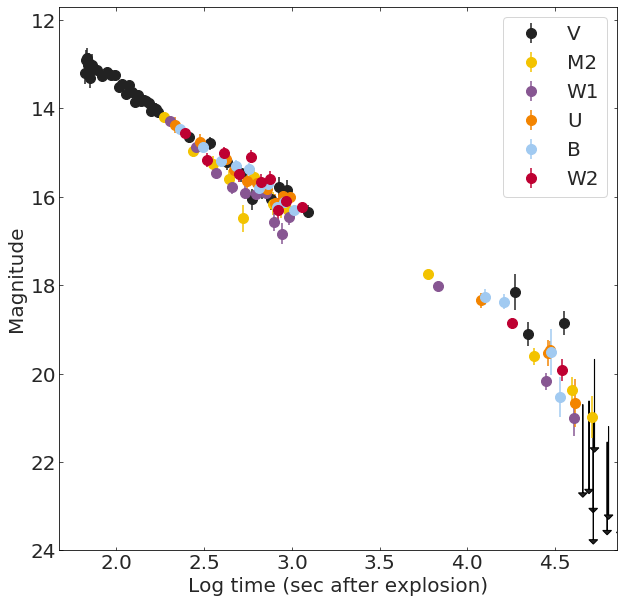

In [5]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#plot the uncertainties
for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"]==f, "logtime"],
                grbAG.loc[grbAG["filter"]==f, "mag"],
                grbAG.loc[grbAG["filter"]==f, "magerr"],
                fmt='o', ms=10, label= f)
    
#plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2,
             head_width=0.05, head_length=0.1, ec='k')
    
pl.ylim(24,11.7)          
pl.legend()
pl.ylabel("Magnitude", fontsize=20)
pl.xlabel("Log time (sec after explosion)", fontsize=20);

The above figure represents the magnitude of the flux of each photometric band from exploding star vs log time (in seconds after explosion). The vertical bar centered around the marker represents the error limit in flux reading. The arrows shows the upperlimit of each band. The plot is flipped in y-axis since magnitude measurements is an inverse scale.

#Findign the linear fit to the given data set

In this exercise we try to do linear fitting of the data in several methods like direct solution, using sklearn package as well as minimizing the objective function (l1 and chi2) and compare those fittings 

Normal linear fitting by solving the equation

In [6]:
x = grbAG[grbAG.upperlimit == 0].logtime.values

X = pl.c_[pl.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)), x]

y = grbAG.loc[grbAG.upperlimit == 0].mag.values

# linear fit solution from equation
theta_best = pl.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


Fitting the line using sklearn package

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)

print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


Fitting the data by minimizing the objective function L1

In [8]:
from scipy.optimize import minimize

def line(x, intercept, slope):
    return slope * x + intercept

def l1(args, x, y):
    a, b = args
    return sum(abs(y - line(x, b, a)))

initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
#print(l1Solution)
#print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


Fitting the data by minimizing the objective function chi2

In [11]:
def chi2(args, x, y, s):
    a, b = args
    return sum((line(x, b, a) - y)**2 / s)

s = grbAG[grbAG.upperlimit == 0].magerr.values

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

#print(chi2Solution)
#print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

best fit parameters from the minimization of the chi squared: slope 2.50, intercept 8.58


#Plotting all the solutions with the data

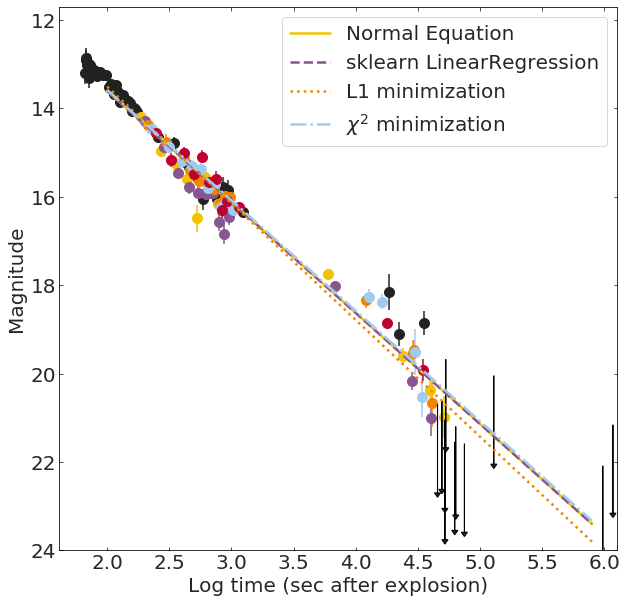

In [12]:
def plotline(x, solution, color = 'k', label = 'fit', ls='-'):    
    ax.plot(x, solution[0] * x + solution[1], color,
            label = label, ls = ls, lw = 2.5, zorder = 3)
    
ax = pl.figure(figsize=(10,10)).add_subplot(111)

# Plotting the data and upperlimits
for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"]==f, "logtime"],
                grbAG.loc[grbAG["filter"]==f, "mag"],
                grbAG.loc[grbAG["filter"]==f, "magerr"],
                fmt='o', ms=10, zorder = 1)
    
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2,
             head_width=0.05, head_length=0.1, ec='k', zorder = 2)
    
x_range = pl.arange(2,6,0.1)

theta_Solution = pl.flip(theta_best)
plotline(x_range, theta_Solution, 'C1', 'Normal Equation','-')
         
sk_Solution = [lr.coef_[1],lr.intercept_]
plotline(x_range, sk_Solution, 'C2', 'sklearn LinearRegression', '--')
         
plotline(x_range, l1Solution.x, 'C3', 'L1 minimization', ':')
         
plotline(x_range, chi2Solution.x, 'C4', r'$\chi^2$ minimization', '-.') 

pl.ylim(24,11.7)          
pl.legend()
pl.ylabel("Magnitude", fontsize=20)
pl.xlabel("Log time (sec after explosion)", fontsize=20);

This plots of magnitude of flux vs log time includes the linear fitting with different approaches together with data, we can see that minimizing the objective function L1 gives the least accurate result whereas chi2 gives a better solution compared to the direct solution. The sklearn package is able to give very good fitting parameters.

#Table with the results of each method


|Method | Slope | Intercept |
|--------|:----------:|---------:|
|Normal| 2.511999| 8.582668 |
|sklearn| 2.511999 | 8.582668 |
| L1    | 2.640233 | 8.226815 |   
| chi2  | 2.499686 | 8.581595 |